In [1]:
!pip install emnist

import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from emnist import *
from skimage import data, io, transform
import matplotlib.pyplot as plt
from keras import backend
from keras.constraints import Constraint

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [2]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

(112800, 28, 28) (112800,)
(48000, 28, 28) (48000,)


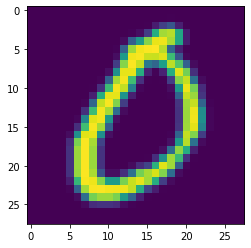

In [3]:
images, labels = extract_training_samples('balanced')
print(images.shape, labels.shape)
ind = []
for i in range(20):
  ind.extend(np.where(labels==i)[0])
images, labels = images[ind], labels[ind]
print(images.shape, labels.shape)
plt.imshow(images[0])

In [4]:
print(labels[0])
print(ind)

0
[156, 160, 168, 256, 278, 355, 383, 401, 432, 482, 506, 542, 574, 618, 650, 699, 701, 750, 875, 884, 957, 968, 969, 1030, 1047, 1151, 1193, 1373, 1396, 1625, 1638, 1640, 1669, 1670, 1743, 1844, 1848, 1898, 1954, 1959, 1991, 2027, 2066, 2283, 2284, 2289, 2338, 2366, 2372, 2419, 2487, 2521, 2536, 2561, 2626, 2630, 2647, 2799, 2887, 2995, 3044, 3064, 3110, 3186, 3199, 3223, 3253, 3276, 3283, 3299, 3343, 3407, 3411, 3454, 3495, 3518, 3534, 3622, 3626, 3706, 3753, 3825, 3852, 3932, 3952, 3981, 4007, 4034, 4040, 4064, 4086, 4087, 4089, 4099, 4116, 4199, 4207, 4241, 4256, 4289, 4413, 4446, 4466, 4510, 4522, 4531, 4575, 4597, 4650, 4668, 4735, 4943, 4992, 5091, 5157, 5160, 5189, 5211, 5225, 5265, 5284, 5342, 5356, 5379, 5409, 5444, 5462, 5497, 5549, 5594, 5601, 5610, 5640, 5669, 5701, 5707, 5726, 5735, 5774, 5803, 5816, 5860, 5877, 5968, 6034, 6082, 6149, 6158, 6283, 6369, 6419, 6427, 6429, 6436, 6455, 6473, 6506, 6614, 6632, 6667, 6702, 6711, 6743, 6811, 6842, 6923, 7045, 7083, 7107, 7140, 

In [0]:
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [0]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [0]:
def define_critic(input_shape=(28, 28, 1), n_classes=47):
    # define the constraint
    const = ClipConstraint(0.01)
    # label input and embedding
    label_in = Input(shape=(1, ))      #label input
    emb = Embedding(n_classes, 50)(label_in)       #embedding for categorical input
    label_h = Dense(input_shape[0] * input_shape[1])(emb)       #scale up to image dimensions with linear activation
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)      #reshape to additional channel
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs   (concatenate label as a channel)
    merge = Concatenate()([image_in, re_label_h])
    # convnet (downsampling)
    h1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same',  kernel_constraint=const)(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same',  kernel_constraint=const)(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net (flatten feature maps and dropout)
    fl = Flatten()(r2) 
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='linear')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    #opt = Adam(lr=2e-4, beta_1=0.5)
    #WGAN optimizer
    opt = RMSprop(lr = 0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)    
    return model

In [0]:
def define_generator(latent_dim, n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)       #linear multiplication
    re_label_h = Reshape((7, 7, 1))(label_h)      #reshape to additional channel
    # noisy image input
    noise_in = Input(shape=(latent_dim,))   #image generator input
    noise_h = Dense(128*7*7)(noise_in)      #foundation for the 7*7 image
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs (merge image generated and label input)
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [0]:
def define_gan(gen, crit):
    # discriminator shouldn't be trainable
    crit.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    # feed to discriminator
    gan_output = crit([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    #opt = Adam(lr=2e-4, beta_1=0.5)
    opt = RMSprop(lr = 0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [0]:
def prepare_inputs(images, labels):
    if len(images.shape) > 2:
      images = np.squeeze(images)
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)  #choose random instances
    X, labels = images[rand_index], labels[rand_index]    #select images and labels
    #y = np.ones((n_samples, 1)) * 0.9 # discriminator target label  
    y = -np.ones((n_samples, 1)) #WGAN critic target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=47):
    xin = randn(latent_dim * n_samples)   #generate points in the latent space
    xin = xin.reshape(n_samples, latent_dim)    #reshape into a batch of inputs for the nwtwork
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)   #generate points in latent space
    images = gen.predict([zin, lin])      #predict outputs
    #y = np.zeros((n_samples, 1))
    y = np.ones((n_samples, 1))  # WGAN critic target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [images, lin], y

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, gan_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, lab], _ = generate_fake_samples(gan_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		plt.subplot(10, 10, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i,:], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [0]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	plt.plot(d1_hist, label='crit_real')
	plt.plot(d2_hist, label='crit_fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	plt.savefig('plot_line_plot_loss.png')
	plt.close()

In [0]:
def train_gan(gen, crit, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128, n_critic = 5):
    batch_per_epoch = int(images.shape[0] / batch_size)
    n_steps = batch_per_epoch * n_epochs  #number of training iterations
    half_batch = int(batch_size / 2)
    c1_hist, c2_hist, g_hist = list(), list(), list()    #lists to keep track of losses
    # enumerate epochs manually
    for i in range(n_steps):
        #update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected "Real" samples
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            #update critic model weights
            c_loss1 = crit.train_on_batch([X_real, labels_real], y_real)
            c1_tmp.append(c_loss1)
            # generate "fake" examples
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            #update critic weights
            c_loss2= crit.train_on_batch([X_fake, labels_fake], y_fake)
            c2_tmp.append(c_loss2)
        #store critic loss
        c1_hist.append(np.mean(c1_tmp))
        c2_hist.append(np.mean(c2_tmp))
        # prepare generator input (points in the latent space)
        [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
        # invert labels for fake samples (prevent vanishing gradients)
        y_gan = -np.ones((batch_size, 1))
        # update generator loss via critic's error
        g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
        g_hist.append(g_loss)
        # summarize loss on this batch
        
        # evaluate model performance on every epoch
        if (i+1) % batch_per_epoch == 0:
            print('> Epoch : %d, Generator: Real loss = %.3f, Fake loss = %.3f, Critic: Loss = %.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
            #summarize_performance(i, gan_model, latent_dim)
            #print('Epoch {}, batch {}/{}:\tCritic: real loss {}, fake loss {}\tGenerator: loss {}'.format(i+1, j+1, batch_per_epoch, c_loss1, c_loss2, g_loss))
    #line plots of loss
    #plot_history(c1_hist, c2_hist, g_hist) 
    # save the models
    gen.save('generator_WGAN.h5')
    crit.save('critic_WGAN.h5')
    gan_model.save('wgan.h5')  

In [14]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
crit = define_critic()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, crit)
print("\nCritic\n")
crit.summary()
print("\nGenerator\n")
gen.summary()
print("\nW-GAN\n")
gan_model.summary()

(48000, 28, 28, 1) (48000,)

Critic

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        2350        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
_________________________________________________________

In [16]:
train_gan(gen, crit, gan_model, images, labels, latent_dim, n_epochs=2, batch_size=128)

> Epoch : 375, Generator: Real loss = -8188.421, Fake loss = -7784.110, Critic: Loss = 8747.169
> Epoch : 750, Generator: Real loss = -12390.375, Fake loss = -13989.822, Critic: Loss = 12728.638


In [17]:
def show_generated(examples, n, c):
  fig = plt.figure(figsize=(c, n))
  for i in range(n*c):
    img = fig.add_subplot(n, c, i+1)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap='gray_r')
  plt.show()

n = 10
c = 20

model = load_model('generator_WGAN.h5')
noise, _ = generate_latent_noise(latent_dim, n*classes)
labs = np.asarray([x for _ in range(n) for x in range(classes)])

X = model.predict([noise, labs])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
x = np.squeeze(X[0])
plt.imshow(x)

show_generated(X, n, c)

NameError: ignored